### Boilerplate

In [1]:
from bs4 import BeautifulSoup
from cycler import cycler
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import json
from datetime import datetime, date, timedelta
import requests
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML('<style>.container {width:90% !important;}</style>'))

plt.style.use('fivethirtyeight')
%matplotlib inline

spark.sql('CREATE DATABASE IF NOT EXISTS football_games')
spark.sql('USE football_games')

os.chdir('../football_data')

In [2]:
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,football_games,coach,False
1,football_games,dvoa,False
2,football_games,game,False
3,football_games,game_line,False
4,football_games,game_metadata,False
5,football_games,game_outcome,False
6,football_games,games_denorm,False
7,football_games,stadium,False
8,football_games,team,False
9,football_games,team_season,False


### Matplotlib Boilerplate

In [3]:
from matplotlib import rcParams

In [4]:
filter(lambda (k,v): 'legend' in k, rcParams.iteritems())

[('legend.borderaxespad', 0.5),
 ('legend.borderpad', 0.4),
 ('legend.columnspacing', 2.0),
 ('legend.edgecolor', '0.8'),
 ('legend.facecolor', 'inherit'),
 ('legend.fancybox', True),
 ('legend.fontsize', 'medium'),
 ('legend.framealpha', 0.8),
 ('legend.frameon', True),
 ('legend.handleheight', 0.7),
 ('legend.handlelength', 2.0),
 ('legend.handletextpad', 0.8),
 ('legend.labelspacing', 0.5),
 ('legend.loc', 'best'),
 ('legend.markerscale', 1.0),
 ('legend.numpoints', 1),
 ('legend.scatterpoints', 1),
 ('legend.shadow', False)]

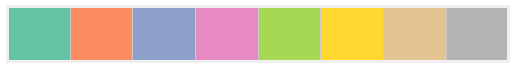

In [5]:
rcParams['axes.titlesize'] = 14
rcParams['axes.titleweight'] = 'bold'
rcParams['figure.titlesize'] = 14
rcParams['figure.titleweight'] = 'bold'
rcParams['text.color'] = '#262626'

rcParams['axes.labelsize'] = 12
rcParams['axes.labelcolor'] = '#262626'
rcParams['axes.labelweight'] = 'bold'

rcParams['legend.fontsize'] = 12

rcParams['figure.figsize'] = (12,8)

# rcParams['figure.dpi'] = 144


## colors
color_palette = 'Set2'
colors = sns.color_palette(color_palette)
sns.palplot(sns.color_palette(color_palette))
rcParams['axes.prop_cycle'] = cycler(color=colors)

### Join/select to get needed data

In [6]:
key = 'game_id'
game = spark.table('game')\
                .select('game_id','season','week_id')\
                .cache()

game_outcome = spark.table('game_outcome')\
                .select('game_id','H_Final','V_Final')\
                .cache()

meta = spark.table('game_metadata')\
                .select('game_id','day_of_week')\
                .cache()

In [7]:
df = game.join(game_outcome, on=key).join(meta, on=key)
assert game.count() == df.count()
assert game_outcome.count() == df.count()
assert meta.count() == df.count()

In [8]:
df.limit(5).toPandas()

,game_id,season,week_id,H_Final,V_Final,day_of_week
0,201511150ram,2015,9,13,37,6
1,201511090sdg,2015,8,19,22,0
2,201510180det,2015,5,37,34,6
3,201512270tam,2015,15,21,26,6
4,201510110kan,2015,4,17,18,6


### Exploring League-wide Game Outcome Trends via Spark

#### Prep Data

In [9]:
df = df.withColumn(
            'winning_team', 
            F.when(col('H_Final') > col('V_Final'), 'H')
             .when(col('H_Final') < col('V_Final'), 'V')
             .otherwise('T')
        ).withColumn(
            'winning_score', 
            F.when(col('winning_team') == 'H', col('H_Final'))
             .otherwise(col('V_Final'))
        ).withColumn(
            'losing_score', 
            F.when(col('winning_team') == 'H', col('V_Final'))
             .otherwise(col('H_Final'))
        ).withColumn(
            'winning_margin', 
            F.abs(col('H_Final') - col('V_Final'))
        ).withColumn(
            'home_net', 
            col('H_Final') - col('V_Final')
        ).withColumn(
            'combined_points',
            col('H_Final') + col('V_Final')
        )

In [10]:
df.limit(5).toPandas()

,game_id,season,week_id,H_Final,V_Final,day_of_week,winning_team,winning_score,losing_score,winning_margin,home_net,combined_points
0,201511150ram,2015,9,13,37,6,V,37,13,24,-24,50
1,201511090sdg,2015,8,19,22,0,V,22,19,3,-3,41
2,201510180det,2015,5,37,34,6,H,37,34,3,3,71
3,201512270tam,2015,15,21,26,6,V,26,21,5,-5,47
4,201510110kan,2015,4,17,18,6,V,18,17,1,-1,35


#### 6 tie games from 2007-2017... this is correct per https://en.wikipedia.org/wiki/List_of_NFL_tied_games

In [11]:
df.filter(col('winning_team') == 'T').toPandas()

,game_id,season,week_id,H_Final,V_Final,day_of_week,winning_team,winning_score,losing_score,winning_margin,home_net,combined_points
0,201610230crd,2016,6,6,6,6,T,6,6,0,0,12
1,201211110sfo,2012,9,24,24,6,T,24,24,0,0,48
2,201311240gnb,2013,11,26,26,6,T,26,26,0,0,52
3,201410120cin,2014,5,37,37,6,T,37,37,0,0,74
4,200811160cin,2008,10,13,13,6,T,13,13,0,0,26
5,201610300cin,2016,7,27,27,6,T,27,27,0,0,54


#### Has the Home-Field Advantage Effect Changed over Time?

In [12]:
winners = df.groupby('winning_team').count().toPandas().set_index('winning_team')
print 'home team wins {:.1f}% of the time'.format(
    winners.loc['H','count'].astype(float) / winners['count'].sum()*100
)
winners

home team wins 57.0% of the time


,count
winning_team,
T,6
V,1257
H,1674


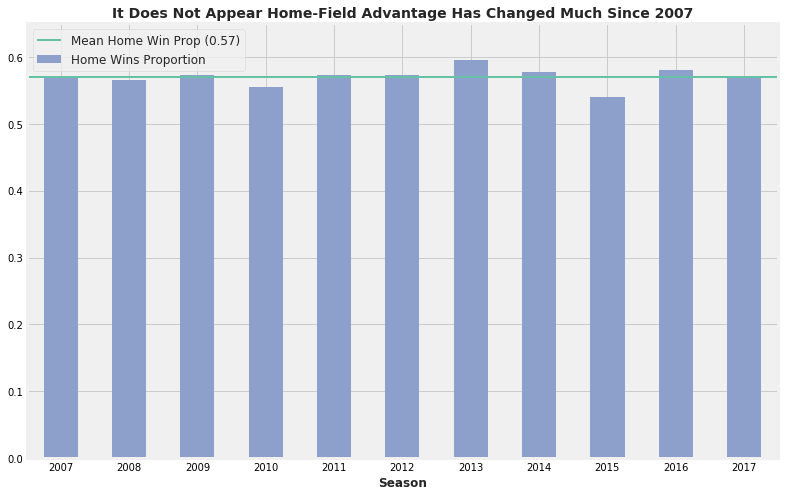

In [13]:
_ = df.groupby('season')\
    .pivot('winning_team')\
    .count()\
    .withColumnRenamed('season', 'Season')\
    .withColumn(
        'Home Wins Proportion',
        col('H') / ( col('H') + F.coalesce('T', F.lit(0)) + col('V') )
    ).toPandas()\
    .set_index('Season')\
    .sort_index()\
    .loc[:, 'Home Wins Proportion']\
    .plot(
        kind='bar', color=colors[2], rot=0,
        title='It Does Not Appear Home-Field Advantage Has Changed Much Since 2007'
    )
_ = plt.axhline(y=0.57, label='Mean Home Win Prop (0.57)', linewidth=2)
_ = plt.ylim([0, 0.65])
_ = plt.legend()

#### How Have Scores and Margins of Victory Changed Over Time?

In [14]:
def agg_scores(df, ngames, scores):
    scores = df.withColumn('prop', F.lit(1) / ngames)\
                       .groupby(scores)\
                       .agg(F.sum('prop').alias('prop'))\
                       .toPandas()\
                       .set_index(scores)\
                       .sort_index()

    assert np.abs(scores['prop'].sum() - 1) < 1e-10

    new_index = np.arange(
        scores.index.min(),
        scores.index.max()+1,
    )

    return scores.reindex(new_index).fillna(0)

ngames = F.lit(float(df.count()))
winning_scores = agg_scores(df, ngames, 'winning_score')
losing_scores = agg_scores(df, ngames, 'losing_score')
margin = agg_scores(df, ngames, 'winning_margin')
home_net = agg_scores(df, ngames, 'home_net')
combined = agg_scores(df, ngames, 'combined_points')

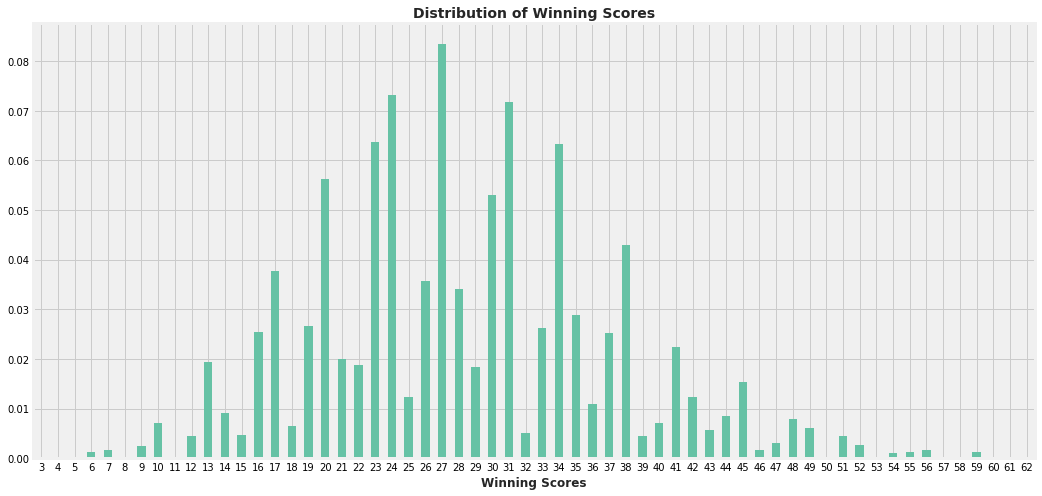

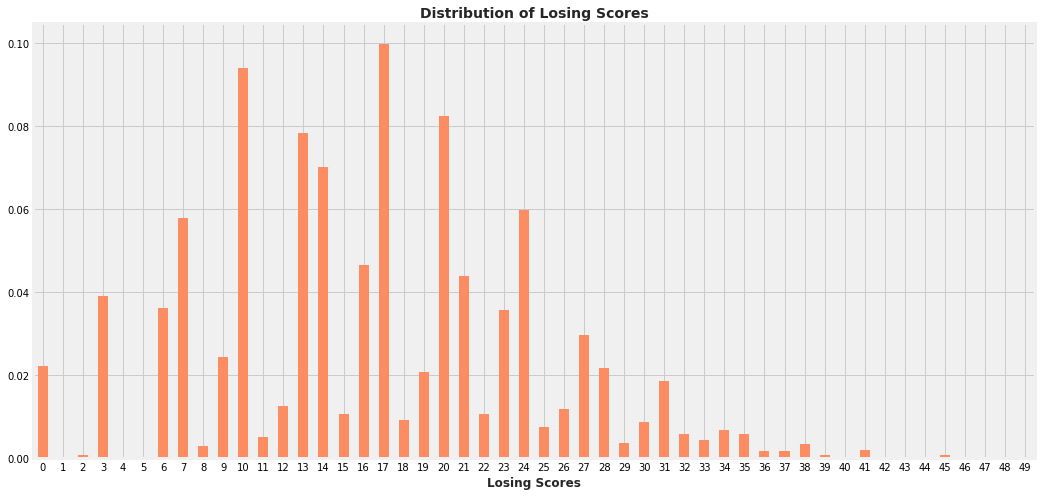

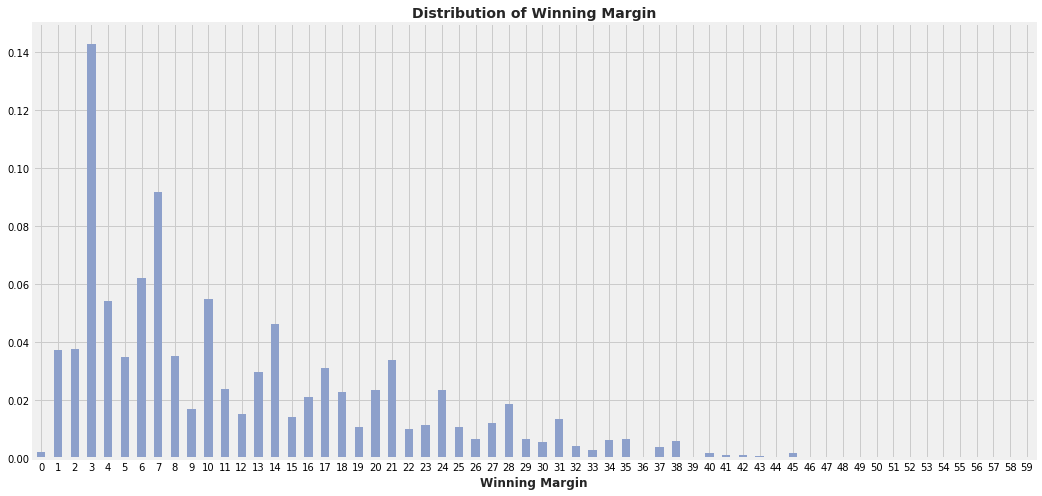

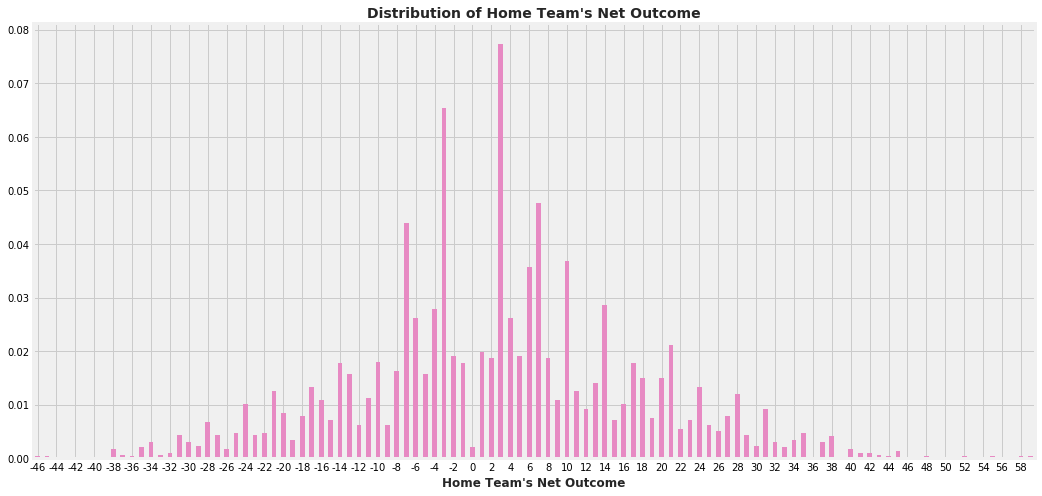

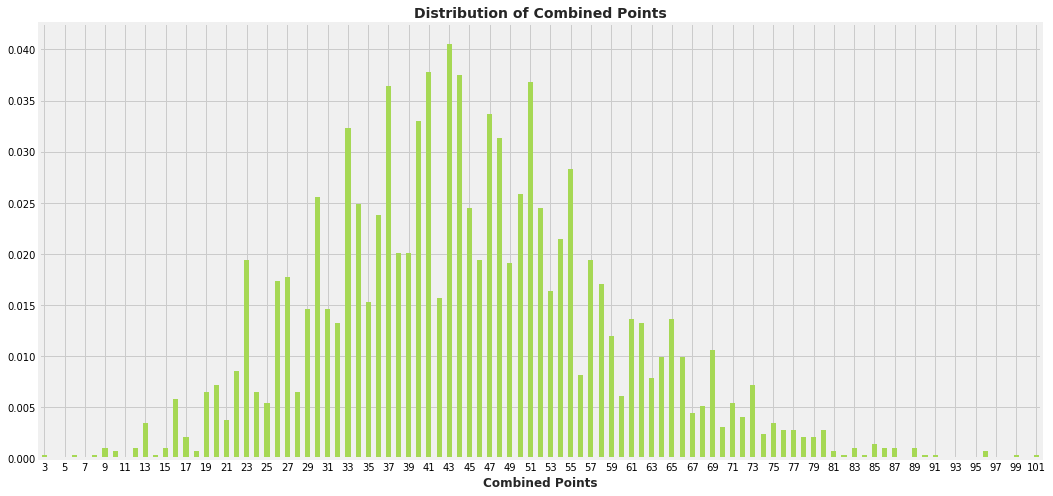

In [15]:
def plot_dist(df, title_prefix, base_title, skiptick, i, plot_type):
    title = 'Distribution of {}'.format(base_title)
    if title_prefix:
        title = '{} {}'.format(title_prefix, title)
    
    df.plot(
        kind=plot_type, figsize=(16,8), rot=0, color=colors[i], 
        legend=None, title=title
    )
    if title_prefix == 'Rolling':
        plt.axhline(y=0.5, color=colors[-1], alpha=0.5, linewidth=2)
    
    plt.xlabel(base_title)
    
    ## skip some tick labels if they're too crowded
    if skiptick > 1:
        a, b = plt.xticks()
        plt.xticks(a[::skiptick], b[::skiptick])
        
        

plot_data = [
    (winning_scores, '', 'Winning Scores', 1),
    (losing_scores, '', 'Losing Scores', 1),
    (margin, '', 'Winning Margin', 1),
    (home_net, '', 'Home Team\'s Net Outcome', 2),
    (combined, '', 'Combined Points', 2),
]

for i, (data, title_prefix, title, skiptick) in enumerate(plot_data):
    plot_dist(data, title_prefix, title, skiptick, i, 'bar')

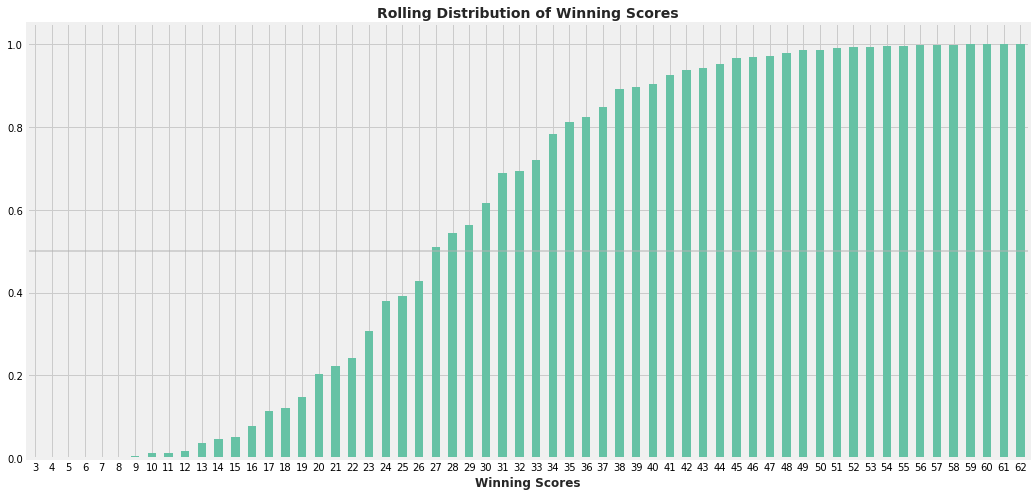

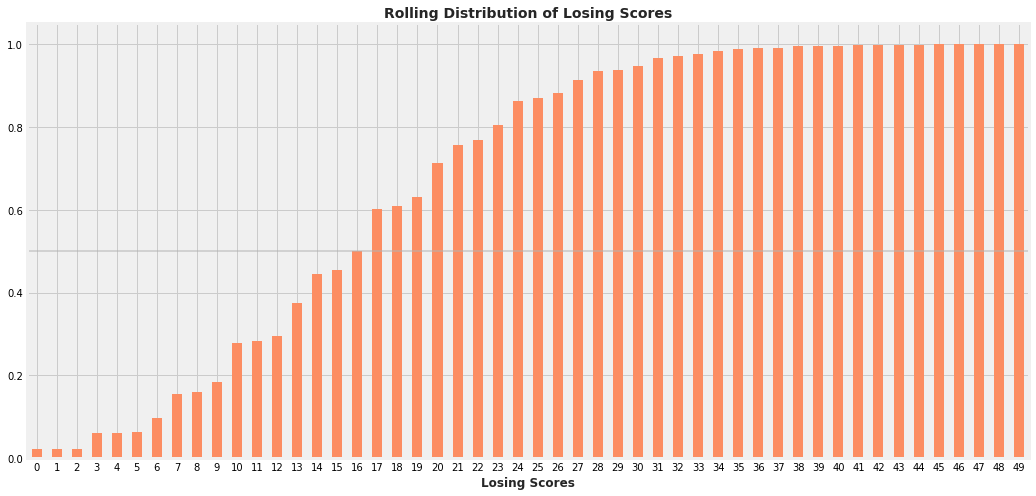

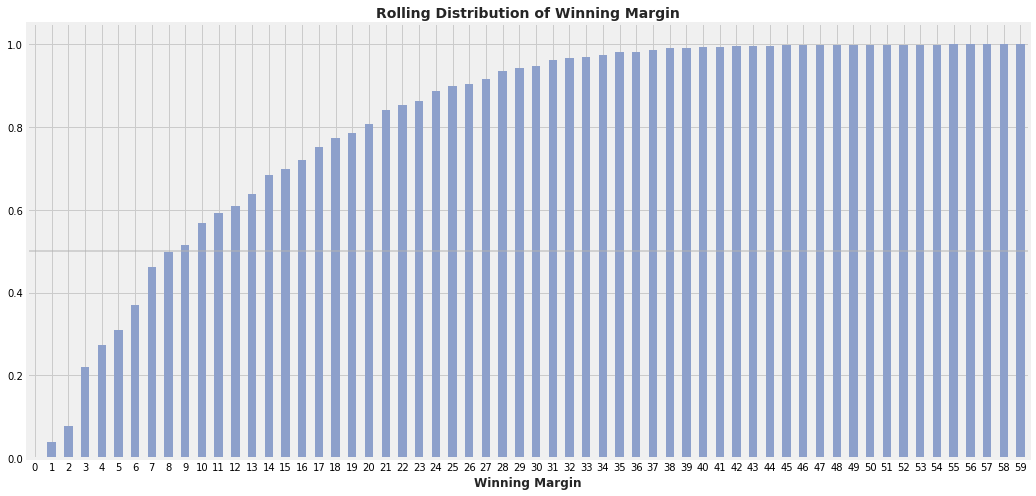

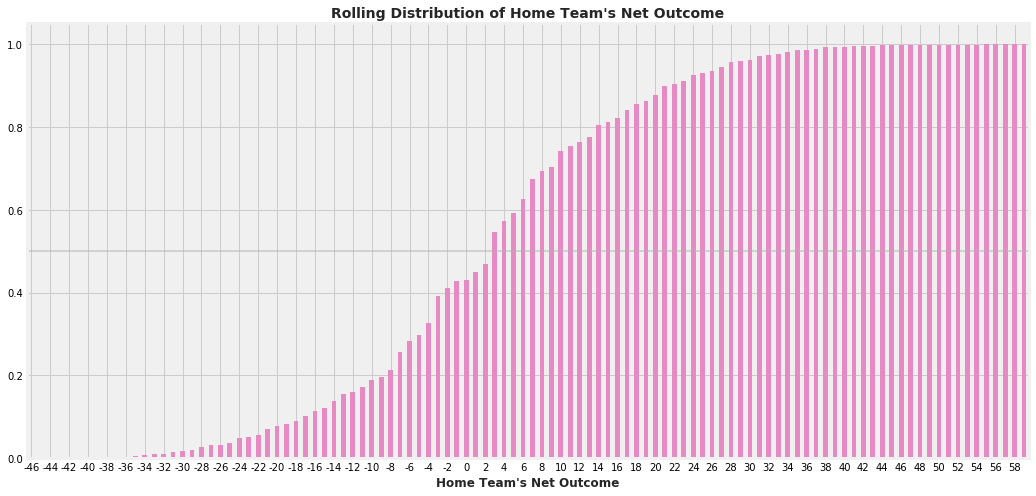

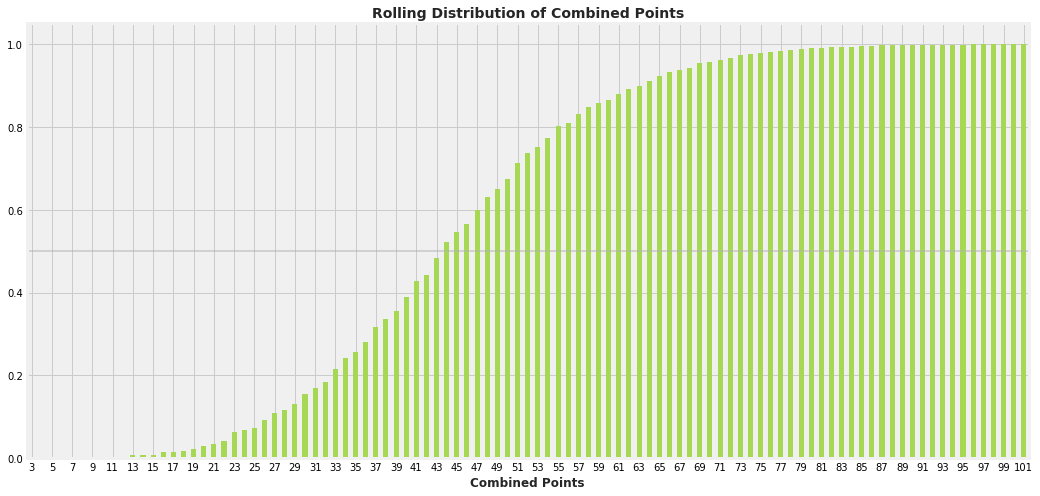

In [16]:
plot_data = [
    (winning_scores.cumsum(), 'Rolling', 'Winning Scores', 1),
    (losing_scores.cumsum(), 'Rolling', 'Losing Scores', 1),
    (margin.cumsum(), 'Rolling', 'Winning Margin', 1),
    (home_net.cumsum(), 'Rolling', 
     'Home Team\'s Net Outcome', 2),
    (combined.cumsum(), 'Rolling', 'Combined Points', 2),
]

for i, (data, title_prefix, title, skiptick) in enumerate(plot_data):
    plot_dist(data, title_prefix, title, skiptick, i, 'bar')

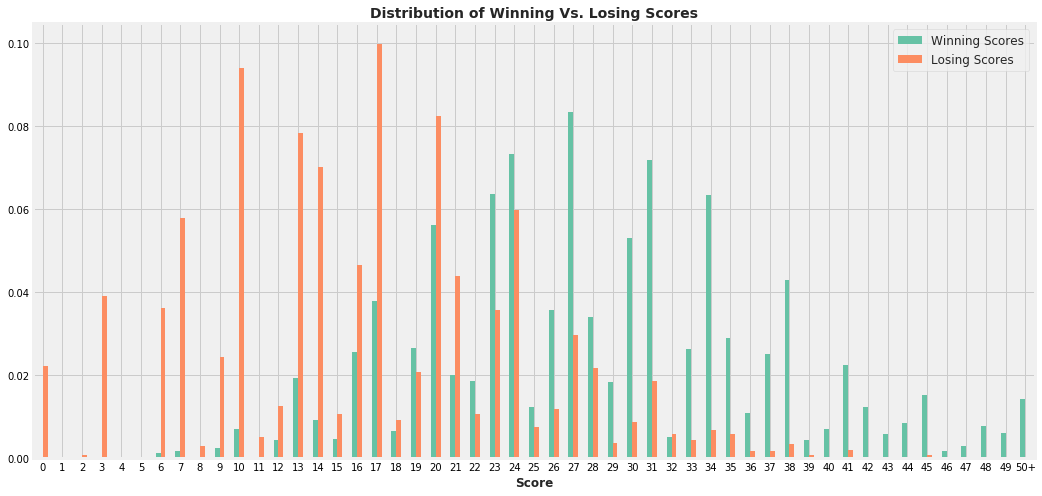

In [17]:
combined_scores = winning_scores.rename(
        columns={'prop':'Winning Scores'}
    ).merge(
        losing_scores.rename(columns={'prop':'Losing Scores'}), 
        left_index=True, right_index=True, how='outer'
    ).fillna(0)

max_losing = combined_scores[combined_scores['Losing Scores'] > 0].index.max()

combined_scores.index.name = 'Score'
combined_scores = combined_scores.reset_index(drop=False)
winning_top_bin = combined_scores[combined_scores['Score'] > max_losing]\
                        ['Winning Scores'].sum()

combined_scores = combined_scores[combined_scores['Score'] <= max_losing]
idx = combined_scores.index.max()+1
combined_scores.loc[idx, :] = ['{}+'.format(max_losing+1), winning_top_bin, 0]
combined_scores['Score'] = combined_scores['Score'].apply(
    lambda x: str(x).split('.')[0]
)
combined_scores.set_index('Score', inplace=True)

_ = combined_scores.plot(
    kind='bar', figsize=(16,8), rot=0
)
_ = plt.title(
    'Distribution of Winning Vs. Losing Scores', 
    color='#262626', fontsize=14, fontweight='bold'
 )

#### What are the most common scores and winning margins

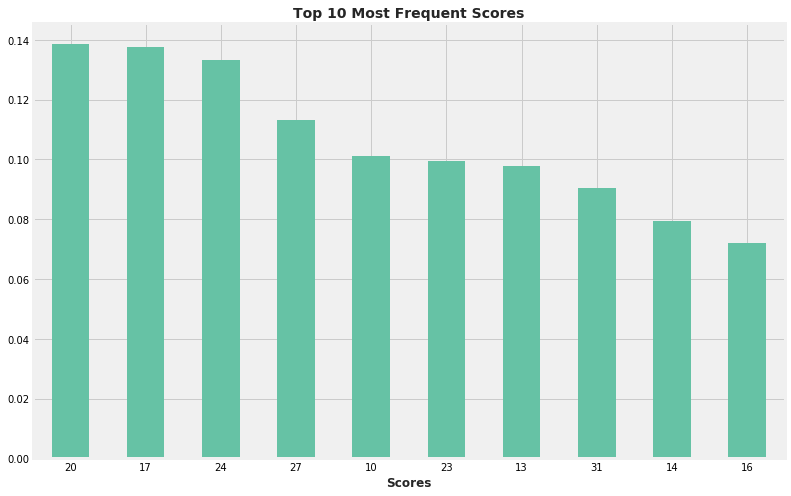

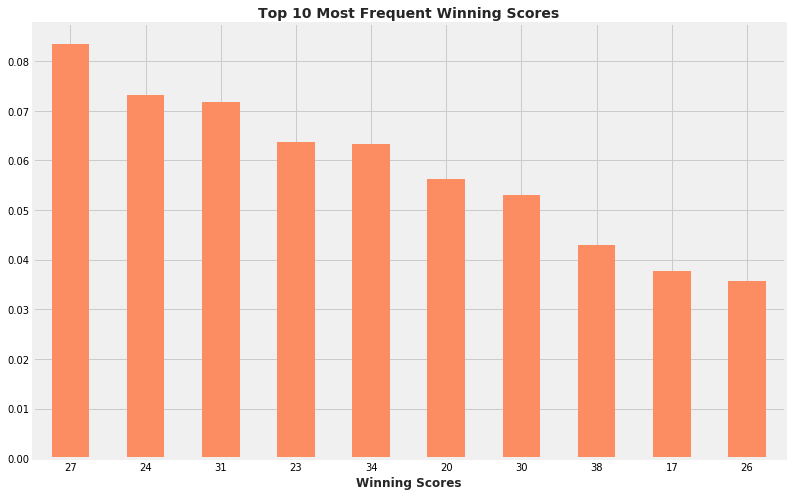

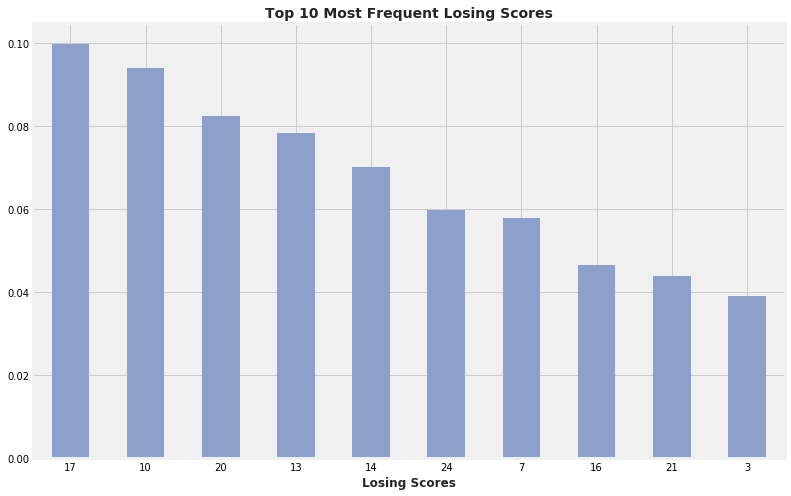

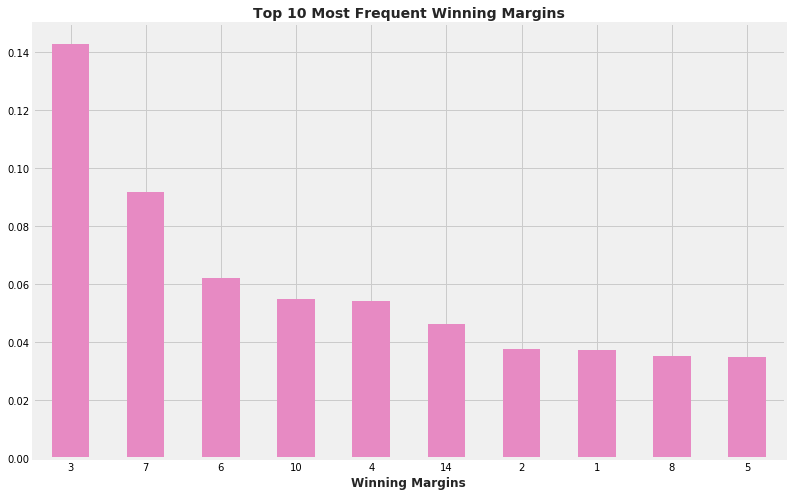

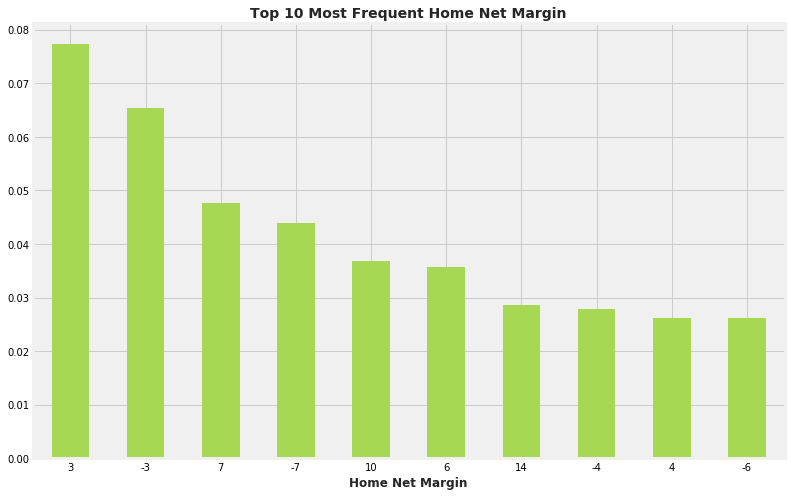

In [18]:
def plot_top_10s(df, title, i):
    '''plot a bar chart with the greatest 10 values'''
    _ = df.sort_values(by='prop', ascending=False).head(10).plot(
            kind='bar', rot=0, legend=None, color=colors[i]
            )
    _ = plt.title('Top 10 Most Frequent {}'.format(title))
    _ = plt.xlabel(title)
    
all_scores = pd.DataFrame(
    winning_scores.merge(
        losing_scores, left_index=True, right_index=True, how='outer'
    ).fillna(0).sum(axis=1)
).rename(columns={0:'prop'})

top_10s = [
    (all_scores, 'Scores'),
    (winning_scores, 'Winning Scores'),
    (losing_scores, 'Losing Scores'),
    (margin, 'Winning Margins'),
    (home_net, 'Home Net Margin')
]

for i, (data, title) in enumerate(top_10s):
    plot_top_10s(data, title, i)

#### How does the margin of error and/or winning score change over (1) time, (2) week, (3) day of week?

In [19]:
df.limit(5).toPandas()

,game_id,season,week_id,H_Final,V_Final,day_of_week,winning_team,winning_score,losing_score,winning_margin,home_net,combined_points
0,201511150ram,2015,9,13,37,6,V,37,13,24,-24,50
1,201511090sdg,2015,8,19,22,0,V,22,19,3,-3,41
2,201510180det,2015,5,37,34,6,H,37,34,3,3,71
3,201512270tam,2015,15,21,26,6,V,26,21,5,-5,47
4,201510110kan,2015,4,17,18,6,V,18,17,1,-1,35


In [20]:
field = 'winning_score'
pivot_col = 'season'

time_trend = df.groupby(field)\
                .pivot(pivot_col)\
                .count()\
                .toPandas()\
                .fillna(0)\
                .set_index(field)

new_index = np.arange(
    time_trend.index.min(),
    time_trend.index.max()+1,
)

time_trend = time_trend.reindex(new_index).fillna(0)

for c in time_trend.columns:
    tot = float(time_trend[c].sum())
    time_trend[c] /= tot

time_trend.head()

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
winning_score,,,,,,,,,,,
3,0.003745,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
6,0.000000,0.0,0.003745,0.000000,0.003745,0.000000,0.0,0.0,0.0,0.003745,0.003745
7,0.000000,0.0,0.003745,0.003745,0.003745,0.007491,0.0,0.0,0.0,0.000000,0.000000


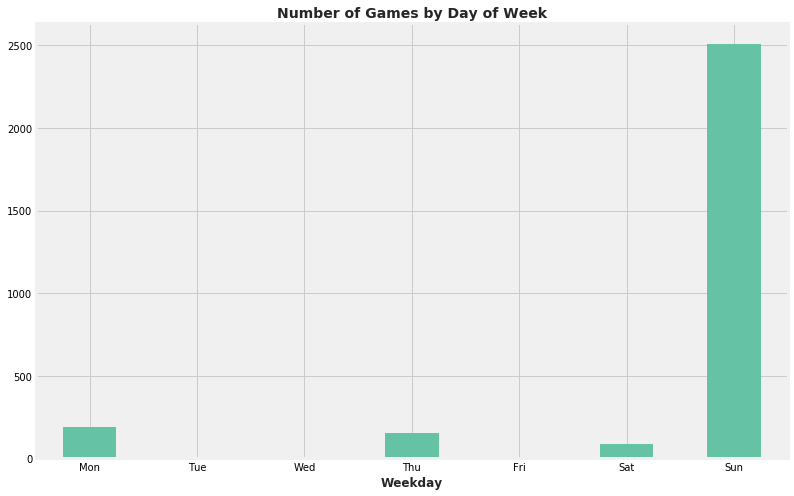

In [21]:
dow_map = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun',
}
dow_map_udf = udf(lambda x: dow_map[x], StringType())

df = df.withColumn('Weekday', dow_map_udf('day_of_week'))
df.groupby('Weekday','day_of_week')\
    .count()\
    .orderBy('day_of_week')\
    .drop('day_of_week')\
    .toPandas()\
    .set_index('Weekday')\
    .plot(
        kind='bar', title='Number of Games by Day of Week', 
        legend=None, rot=0
        )

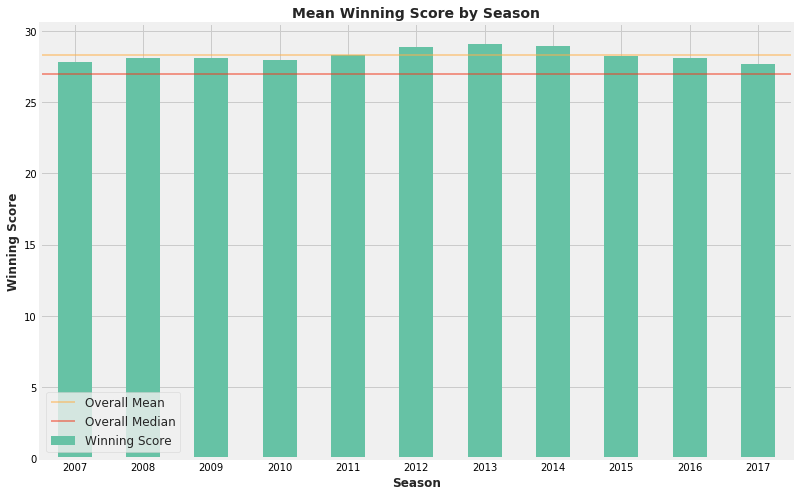

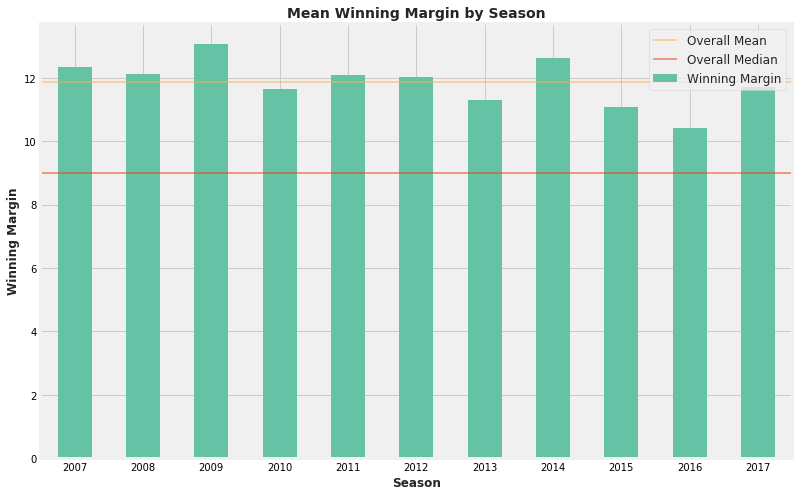

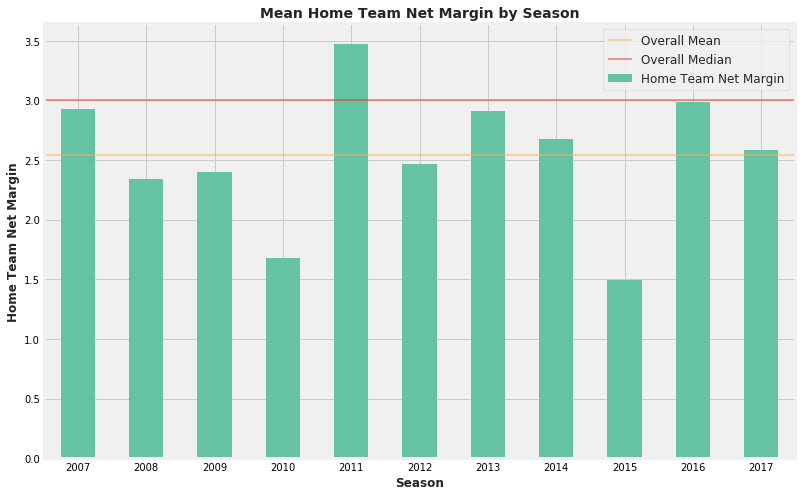

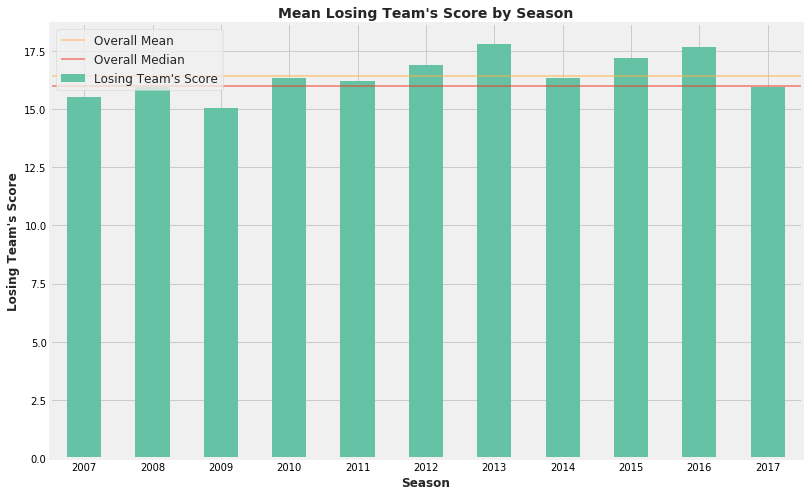

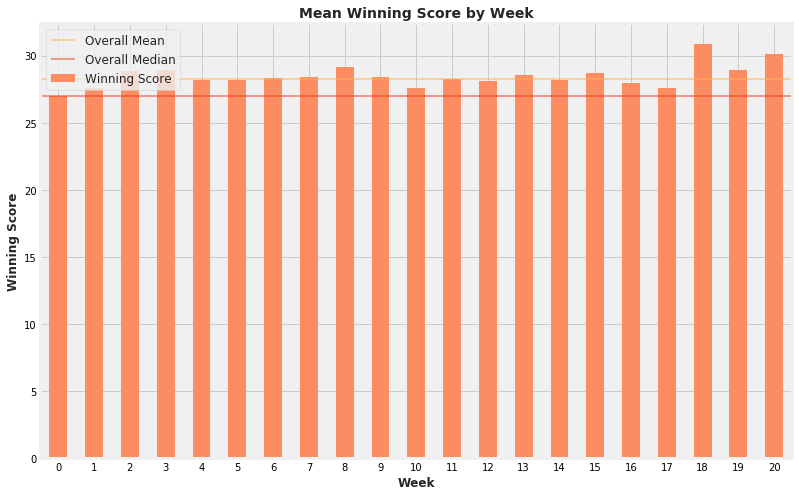

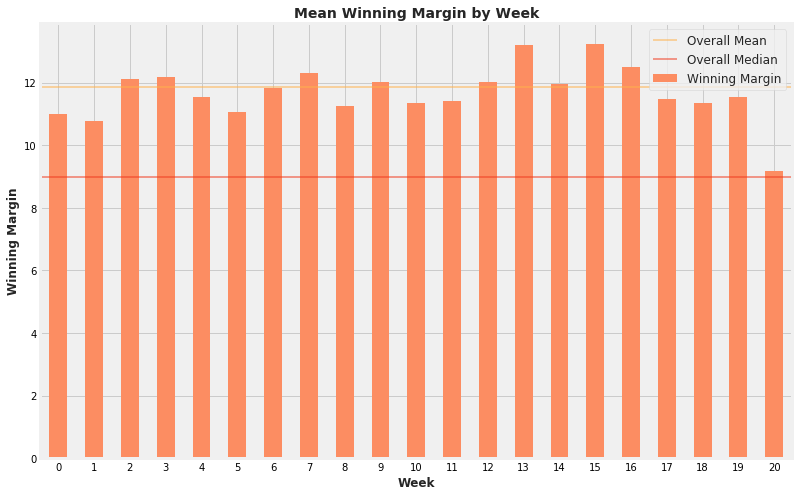

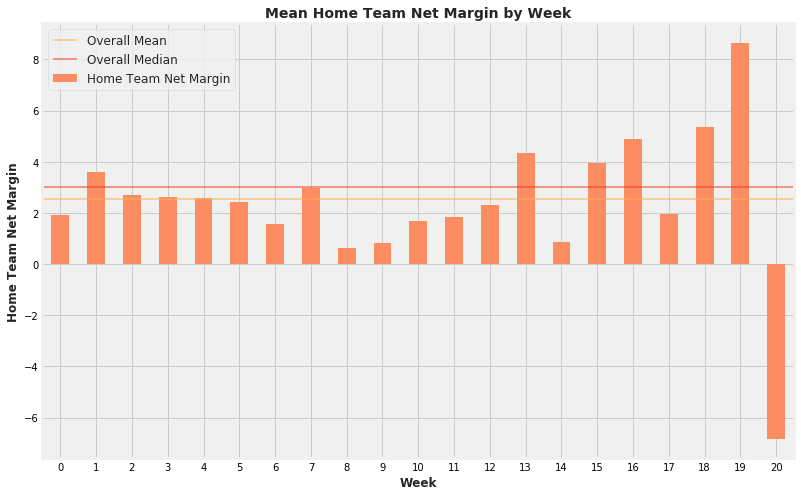

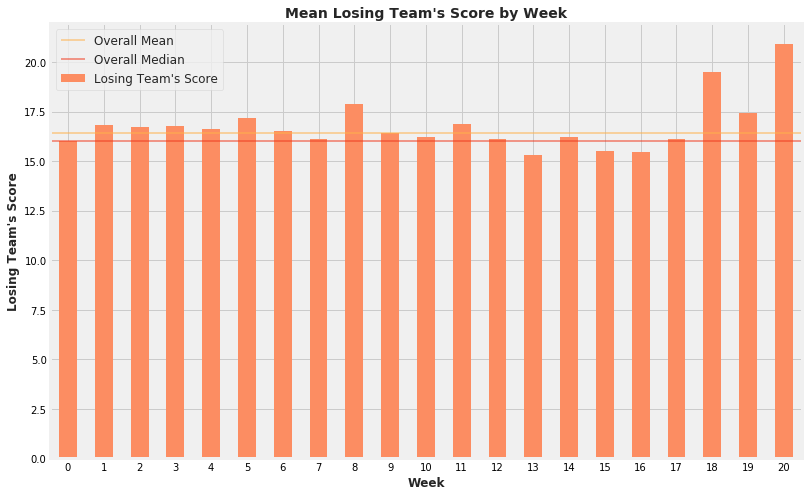

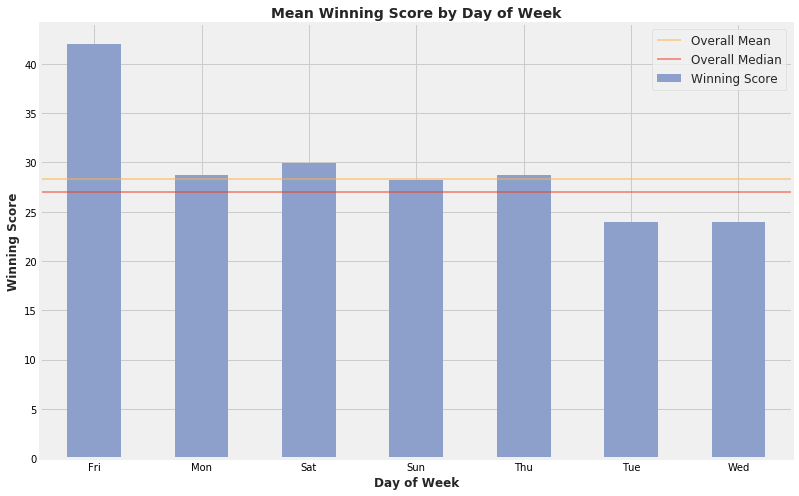

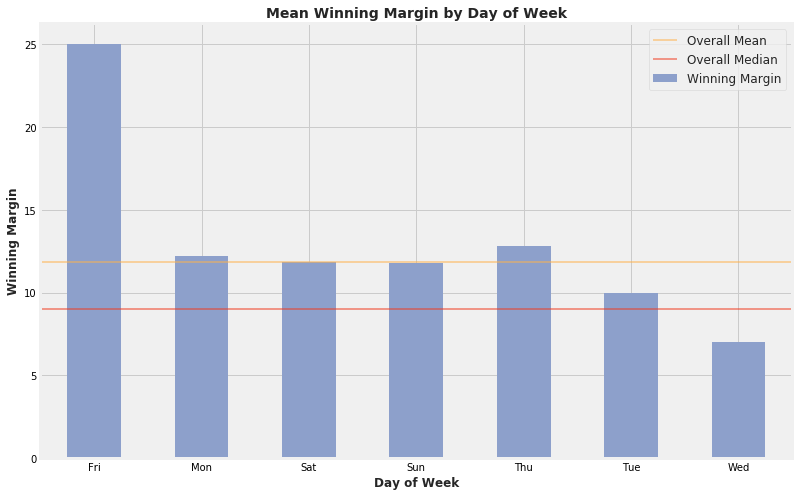

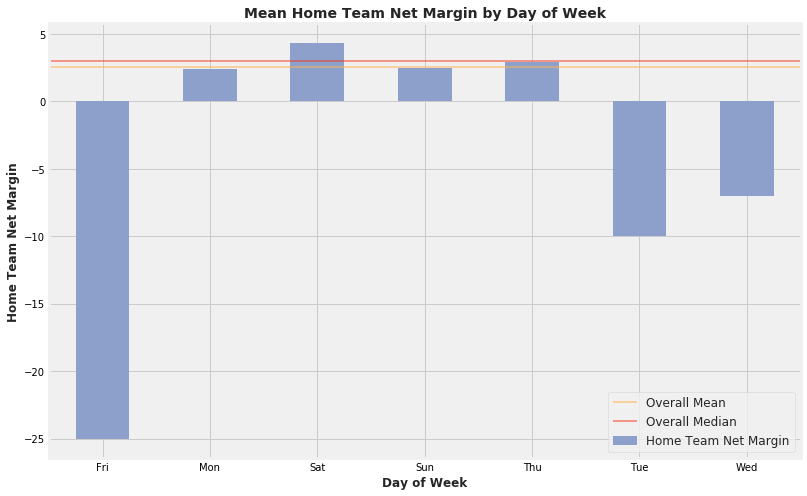

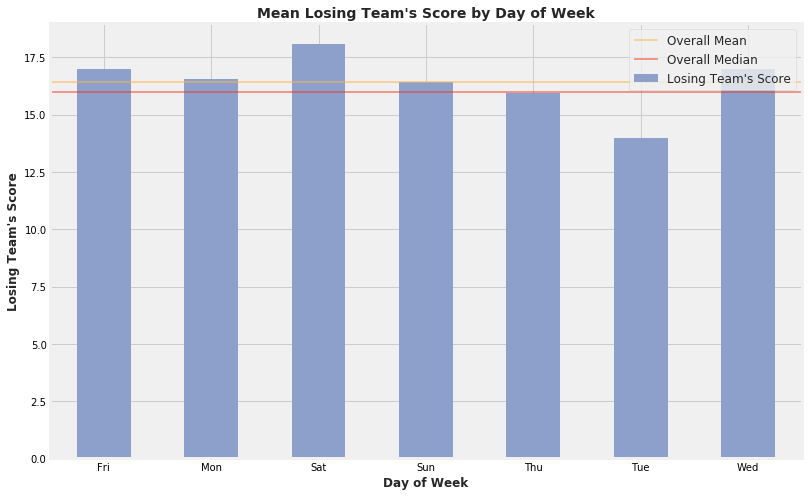

In [22]:
fields = [
    ('season','Season'), 
    ('week_id','Week'), 
    ('Weekday','Day of Week')
]
agg_cols = [
    ('winning_score','Winning Score'), 
    ('winning_margin','Winning Margin'), 
    ('home_net','Home Team Net Margin'), 
    ('losing_score', 'Losing Team\'s Score')
]

for i, (field, field_desc) in enumerate(fields):
    for (agg_col, agg_col_desc) in agg_cols:
        _ = df.groupby(field)\
                .agg(F.mean(agg_col).alias(agg_col))\
                .toPandas()\
                .set_index(field)\
                .rename(columns={agg_col:agg_col_desc})\
                .sort_index()\
                .plot(
                    kind='bar', rot=0, figsize=(12,8), color=colors[i]
                )
        mean_val = df.select(F.mean(agg_col)).toPandas().iloc[0, 0]
        med_val = df.select(
                udf(lambda x: float(np.median(x)), FloatType())
                (F.collect_list(agg_col))
            ).toPandas().iloc[0, 0]
        _ = plt.axhline(y=mean_val, linewidth=2, color='#feb24c', 
                        alpha=0.5, label='Overall Mean')
        _ = plt.axhline(y=med_val, linewidth=2, color='#f03b20', 
                        alpha=0.5, label='Overall Median')
        _ = plt.title('Mean {} by {}'.format(agg_col_desc, field_desc))
        _ = plt.xlabel(field_desc)
        _ = plt.ylabel(agg_col_desc)
        _ = plt.legend()

### Exploring League-wide Line Trends

#### Prep Data

In [23]:
key = 'game_id'
lines = spark.table('game_line')
drop_cols = filter(lambda x: '2H' in x, lines.columns)
lines = lines.drop(*drop_cols)

game = spark.table('game')\
                .select('game_id','season','week_id','is_neutral')\
                .cache()

meta = spark.table('game_metadata')\
                .select('game_id','day_of_week')\
                .cache()

In [24]:
lines.limit(5).toPandas()

,game_id,ML_Fav,H_ML,V_ML,Open_Fav,Open_Spread,Close_Fav,Close_Spread,Open_OU,Close_OU,pfr_ou,pfr_spread,pfr_fav,pfr_fav_id
0,201511150ram,H,-380,310,H,7.0,H,7.5,43.0,42.0,42.5,6.5,H,ram
1,201511090sdg,H,-200,170,H,4.5,H,3.5,52.0,49.5,49.5,4.5,H,sdg
2,201510180det,H,-200,170,H,3.0,H,3.5,44.0,45.0,44.0,3.0,H,det
3,201512270tam,H,-165,145,H,2.5,H,3.0,46.5,43.5,45.0,3.0,H,tam
4,201510110kan,H,-428,347,H,10.0,H,9.0,46.5,43.5,45.0,9.0,H,kan


In [26]:
df = lines.join(game, on=key)\
          .join(meta, on=key)\
          .cache()
assert lines.count() == df.count()
assert game.count() == df.count()
assert meta.count() == df.count()

df = df.filter(col('is_neutral') == 0)

In [27]:
df.limit(5).toPandas()

,game_id,ML_Fav,H_ML,V_ML,Open_Fav,Open_Spread,Close_Fav,Close_Spread,Open_OU,Close_OU,pfr_ou,pfr_spread,pfr_fav,pfr_fav_id,season,week_id,is_neutral,day_of_week
0,201511150ram,H,-380,310,H,7.0,H,7.5,43.0,42.0,42.5,6.5,H,ram,2015,9,0,6
1,201511090sdg,H,-200,170,H,4.5,H,3.5,52.0,49.5,49.5,4.5,H,sdg,2015,8,0,0
2,201510180det,H,-200,170,H,3.0,H,3.5,44.0,45.0,44.0,3.0,H,det,2015,5,0,6
3,201512270tam,H,-165,145,H,2.5,H,3.0,46.5,43.5,45.0,3.0,H,tam,2015,15,0,6
4,201510110kan,H,-428,347,H,10.0,H,9.0,46.5,43.5,45.0,9.0,H,kan,2015,4,0,6


#### How often is Home favorite? In open vs. close line?

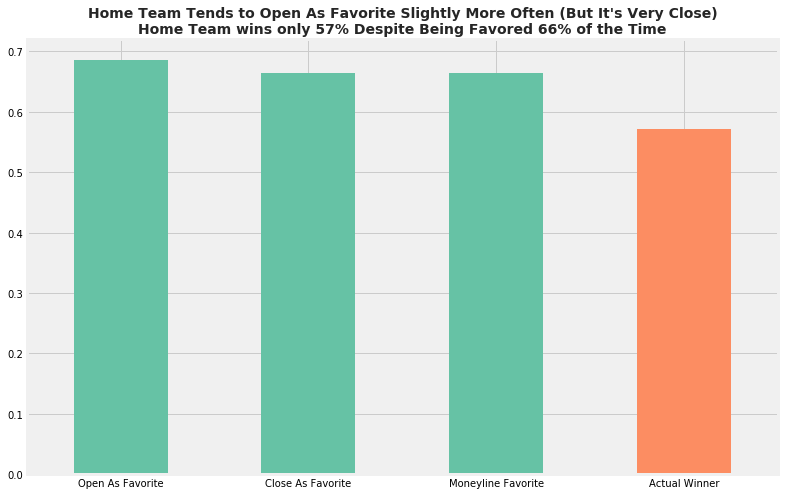

In [103]:
a = df.groupby('Open_Fav')\
      .count()\
      .toPandas()\
      .set_index('Open_Fav')\
      .rename(columns={'count':'Open As Favorite'})

b = df.groupby('Close_Fav')\
      .count()\
      .toPandas()\
      .set_index('Close_Fav')\
      .rename(columns={'count':'Close As Favorite'})

c = df.groupby('ML_Fav')\
      .count()\
      .toPandas()\
      .set_index('ML_Fav')\
      .rename(columns={'count':'Moneyline Favorite'})

winners = winners.rename(columns={'count':'Actual Winner'})
## winners DF is the actual winners

opcl = a.merge(b, left_index=True, right_index=True)\
        .merge(c, left_index=True, right_index=True)\
        .merge(winners, left_index=True, right_index=True)\
        .fillna(0)\
        .T
opcl['Home Prop'] = opcl['H'].astype(float) / opcl.sum(axis=1)

opcl['Home Prop'].plot(
    kind='bar', rot=0, legend=None, 
    color=[colors[0], colors[0], colors[0], colors[1]],
    title='Home Team Tends to Open As Favorite Slightly More Often '
          + '(But It\'s Very Close)\n'
          + 'Home Team wins only 57% Despite Being Favored 66% of the Time'
)

#### Comparing PFR Line to SBR

In [31]:
## standardize the lines: negative means home fav
df = df.withColumn(
        'sbr_open',
        F.when(col('Open_Fav') == 'H', -1*col('Open_Spread'))
         .when(col('Open_Fav') == 'V', col('Open_Spread'))
         .otherwise(0)
    ).withColumn(
        'sbr_close',
        F.when(col('Close_Fav') == 'H', -1*col('Close_Spread'))
         .when(col('Close_Fav') == 'V', col('Close_Spread'))
         .otherwise(0)
    ).withColumn(
        'pfr',
        F.when(col('pfr_fav') == 'H', -1*col('pfr_spread'))
         .when(col('pfr_fav') == 'V', col('pfr_spread'))
         .otherwise(0)
    )

In [32]:
df.select('sbr_open','sbr_close','pfr').limit(5).toPandas()

,sbr_open,sbr_close,pfr
0,-7.0,-7.5,-6.5
1,-4.5,-3.5,-4.5
2,-3.0,-3.5,-3.0
3,-2.5,-3.0,-3.0
4,-10.0,-9.0,-9.0


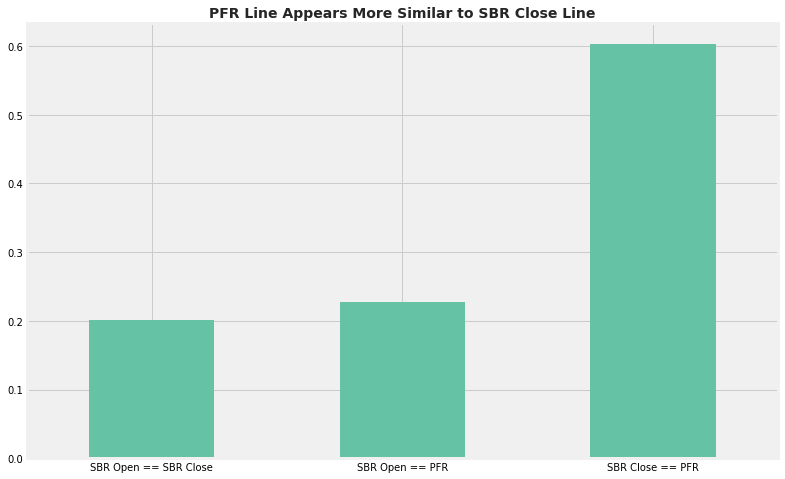

In [45]:
## how often are they equal
df.select('sbr_open','sbr_close','pfr').withColumn(
        'SBR Open == SBR Close',
        (col('sbr_open') == col('sbr_close')).cast(IntegerType())
    ).withColumn(
        'SBR Open == PFR',
        (col('sbr_open') == col('pfr')).cast(IntegerType())
    ).withColumn(
        'SBR Close == PFR',
        (col('sbr_close') == col('pfr')).cast(IntegerType())
    ).select(
        F.mean('SBR Open == SBR Close').alias('SBR Open == SBR Close'),
        F.mean('SBR Open == PFR').alias('SBR Open == PFR'),
        F.mean('SBR Close == PFR').alias('SBR Close == PFR')
    ).toPandas().T.plot(
        kind='bar', rot=0, legend=None,
        title='PFR Line Appears More Similar to SBR Close Line'
    )

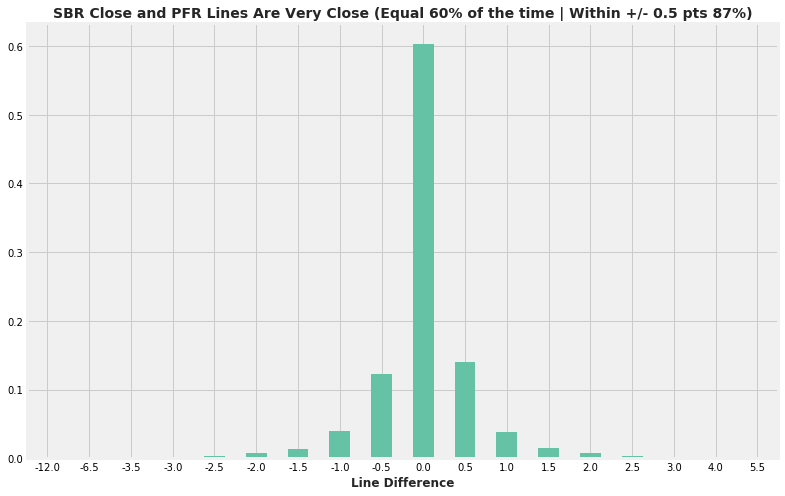

In [65]:
ngames = F.lit(float(df.count()))
df.withColumn(
        'prop', 
        F.lit(1) / ngames
    ).withColumn(
        'Line Difference',
        col('sbr_close') - col('pfr')
    ).groupby('Line Difference')\
    .agg(F.sum('prop').alias('prop'))\
    .toPandas()\
    .set_index('Line Difference')\
    .sort_index()\
    .plot(kind='bar', legend=None, rot=0,
         title='SBR Close and PFR Lines Are Very Close ' \
               '(Equal 60% of the time | Within +/- 0.5 pts 87%)')

#### How does the SBR line shift from open to close?

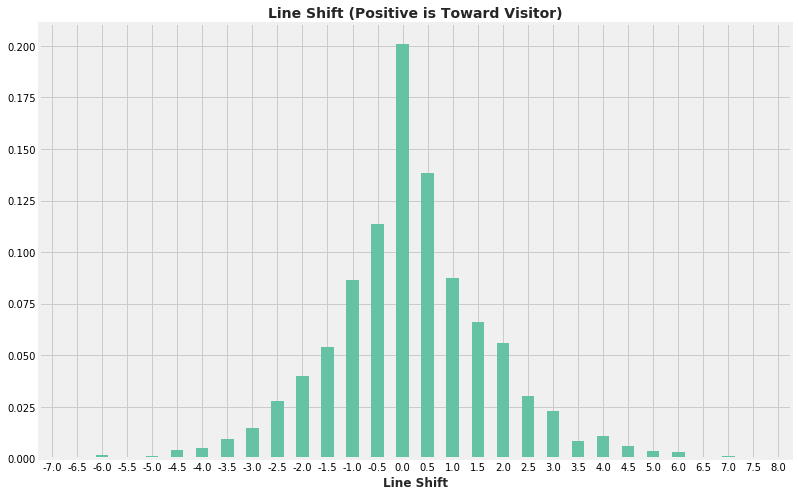

In [73]:
ngames = F.lit(float(df.count()))
df.withColumn(
        'prop', 
        F.lit(1) / ngames
    ).withColumn(
        'Line Shift',
        col('sbr_close') - col('sbr_open')
    ).groupby('Line Shift')\
    .agg(F.sum('prop').alias('prop'))\
    .toPandas()\
    .set_index('Line Shift')\
    .sort_index()\
    .loc[-7.:8., :]\
    .plot(kind='bar', legend=None, rot=0,
         title='Line Shift (Positive is Toward Visitor)')

#### Moneyline Favorites

In [84]:
ml_favs = df.groupby('ML_Fav').count().toPandas().set_index('ML_Fav').T
ml_favs['Home Favorite Prop'] = ml_favs['H'] / ml_favs.sum(axis=1)
ml_favs

ML_Fav,V,pickem,H,Home Favorite Prop
count,961,33,1904,0.657005


In [75]:
df.limit(5).toPandas().T

,0,1,2,3,4
game_id,201511150ram,201511090sdg,201510180det,201512270tam,201510110kan
ML_Fav,H,H,H,H,H
H_ML,-380,-200,-200,-165,-428
V_ML,310,170,170,145,347
Open_Fav,H,H,H,H,H
Open_Spread,7,4.5,3,2.5,10
Close_Fav,H,H,H,H,H
Close_Spread,7.5,3.5,3.5,3,9
Open_OU,43,52,44,46.5,46.5
Close_OU,42,49.5,45,43.5,43.5


#### Have Lines Priced Home-Field Advantage Differently over Time?

In [ ]:
lines.groupby('')